## <font color=red>IBM Data Science Capstone</font>
This notebook will be used to develop the project for the final course in the IBM Data Science Certification.

#### <font color=blue>Introduction/Business Problem</font>

**Background:**  
An important step in opening an business is zeroing on its location; the revenue of a business is highly correlated to how good its location is - businesses located highly close to each other have to split potential revenue while businesses located very remotely suffer in the other direction. So it would be essential to identify potential areas that would be promising in terms of revenue it could generate from customers. 

#### Clustering of Businesses
It is generally observed that businesses open shop closeby, contrary to general reasoning that it could hurt customer turnout. Such clustering phenomenon though is explained by Game Theory when you have commodities which are reasonably interchangable, such as retailers.
  
Consider a retailer/business that has a monopoly. It could simply open shop at its location of choice and force customers to reached out for them. However, the threat of competition forces stores to try to determine a location that captures maximum market share. In other words, they want to be in central location for their target audience, minimizing the distance consumers have to travel. In the mean time, all competing businesses are simultaneously making the same decision which means the resulting stores end up clustered together.
  
If a retailer opens a new location away from the current clustering, there are two potential results:
1. It will fail to capture enough consumers and eventually close.
2. It will become successful causing competitive stores to locate nearby.

Either way, clustering remains the norm. Such a behaviour is sometimes explained in economics using Nash Equilibruim.

<img src="https://img.grouponcdn.com/seocms/9qgBTG472GYgj88p1JvhRT/foods-600x390">

**Problem: Identify Restaurent Location based on Cuisine**  
Identify restaurents according to cuisines with most footfall in the city, in our case,  ``London`` and cluster the neighbourhoods accordingly to identify where the one could open silimar restaurents. 

**Target Audience**  
Restaurents wanting to open up in areas where demand is high could make use of the conclusions from the report. On the other hand, if the business had an approach to avoid areas where there are already serving large number of customers and instead focus on areas outside the high footall areas may instead avoid these areas when considering to open a new business. 

**Approach**  
1. Identify restaurent cuisines and cluster them according to neighbourhoods(Bouroughs) in London.
2. Identify the type of customers one can expect using land prices as a proxy.

### Data Section
  
The data to identify the neighborhoods in London can be scrapped from wikipedia page on [London Bouroughs](https://en.wikipedia.org/wiki/List_of_London_boroughs). The table can be scrapped using BeautifulSoup Library. The data includes, amongst others:
1. Borough	
2. Local authority	
3. Political control
4. Area (sq mi)	
5. Population (2013 est)
6. Co-ordinates
  
For the sake of analysis, only coordinates and boroughs are necessary. Those coordinates will be later used to build a list of business within a certain radius from it and fed into the Foursquare API to get the details of number so customers to visit them. The frequency of visits will be calculated and the boroughs will be clustered according to algorithms to identify the boroughs with high demand for certain businesses. 

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd 

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table', class_='wikitable sortable')

In [3]:
rows = table.find_all('tr') #saving all the rows from the table.
columns = rows[0].find_all('th')
columns = [column.get_text(strip=True) for column in columns]
columns

['Borough',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [4]:
table_pd = pd.DataFrame(columns=list(range(len(columns))), index=range(len(rows)-1)) #defining the table structure
for i_row, val_row in enumerate(rows):                             #Looping over the rows
    cols = val_row.find_all('td')                                  #Extracting columns from each row as a list
    cols = [col.get_text(strip=True) for col in cols]              #Striping for text between tags
    for idx, val in enumerate(cols):                               #Looping over the columns in each row into DataFrame
        table_pd[idx][i_row-1] = val

### Customer Type 
Land Prices for the city of London can be obtained from the HM Land Registry website [Land value estimates for policy appraisal 2017.](https://www.gov.uk/government/publications/land-value-estimates-for-policy-appraisal-2017) The downloaded Excel File can be uploaded into a panda Data Frame. The average land prices per hactare mapped by borough can be extracted from this data as shown below:
**Note**- The sheet one containing the residential land prices has been considered.

In [5]:
df_prices = pd.read_excel('Land_value_estimates.xlsx', sheet_name=0)

#Extracting relavant Columns and renaming.
df_prices_london = df_prices[(df_prices['Residential Land'] == 'London') & (df_prices['Unnamed: 2'] != 'City of London')][['Unnamed: 2', 'Unnamed: 3']] 
df_prices_london.reset_index(drop=True, inplace=True)
df_prices_london.rename(columns={'Unnamed: 2':'Neighbourhood', 'Unnamed: 3':'Price (Pounds)'}, inplace=True)
df_prices_london.head()

Neighbourhood Price (Pounds)
0  Barking and Dagenham        5400000
1                Barnet       24900000
2                Bexley       10300000
3                 Brent       16800000
4        Bromley London       17700000

### Extracting Relavant Data
The table below can be derived from the scrapped table in wikipedia page shown above.

In [6]:
#Extracting Geographic Co-ordinates

import re
Latitudes = []
Longitudes = []
for i in range(len(table_pd[8])):
    extract = re.findall('/\\d*\..*;.*\d*\.\d*', table_pd[8][i])
    lat_long = extract[0][1:].split('; ')
    Latitudes.append(float(lat_long[0]))
    Longitudes.append(float(lat_long[1]))
    
table_pd['Latitude'] = Latitudes
table_pd['Longitude'] = Longitudes

table_pd.rename(columns={key:value for key, value in zip(list(table_pd.columns), columns)}, inplace=True)


In [7]:
#Renaming and extracting relavant columns
london_data = table_pd[['Borough', 'Latitude', 'Longitude']].reindex()
london_data['Borough'] = london_data['Borough'].str.replace('\[note (1|2|4)\]', '', regex=True)
london_data.rename(columns={'Borough':'Neighbourhood'}, inplace=True)
london_df = pd.concat([london_data, df_prices_london['Price (Pounds)']], axis=1)

london_df.head()

Neighbourhood  Latitude  Longitude Price (Pounds)
0  Barking and Dagenham   51.5607     0.1557        5400000
1                Barnet   51.6252    -0.1517       24900000
2                Bexley   51.4549     0.1505       10300000
3                 Brent   51.5588    -0.2817       16800000
4               Bromley   51.4039     0.0198       17700000

In [8]:
from geopy.geocoders import Nominatim
import folium

address = 'London, UK'
geolocator = Nominatim(user_agent="lo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
london_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(london_data['Latitude'], london_data['Longitude'], london_data['Neighbourhood']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london_map)  
    
london_map

In [9]:
CLIENT_ID = 'XRJ4LHM2APB4XIXQTVLGBSHOBMW1HULWBCX2PZD1CP25MOVY' # your Foursquare ID
CLIENT_SECRET = 'INN0D04BPYZA5D4EUGTFXW5RQ1VQFSUBVPBXICYIEUMVITEN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

from pandas.io.json import json_normalize

radius = 500
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
london_venues = getNearbyVenues(names=london_data['Neighbourhood'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude']
                                  );

In [11]:
london_venues = london_venues.loc[london_venues['Neighbourhood'] != 'Barking and Dagenham']
london_venues.reset_index(drop=True, inplace=True)
london_venues.head(5)

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0        Barnet                 51.6252                  -0.1517   
1        Barnet                 51.6252                  -0.1517   
2        Barnet                 51.6252                  -0.1517   
3        Bexley                 51.4549                   0.1505   
4        Bexley                 51.4549                   0.1505   

                    Venue  Venue Latitude  Venue Longitude  \
0              The Atrium       51.624726        -0.151933   
1  Beaconsfield Road (BF)       51.622827        -0.151466   
2           Oakleigh Cafe       51.623412        -0.154899   
3                   Wilko       51.456257         0.148608   
4                   Zizzi       51.455929         0.150555   

           Venue Category  
0                    Café  
1                Bus Stop  
2                    Café  
3  Furniture / Home Store  
4      Italian Restaurant

In [12]:
searchfor = ['Café', 'Place', 'Joint', 'Diner', 'Restaurant', 'Bistro', 
             'Gathering', 'Brakfast', 'Steakhouse']
southasian = ['Chaat', 'Pakistani', 'Indian']    
chinese=['Asian', 'Chinese', 'Szechuan', 'Cantonese', 'Dim Sum', 'Dumpling']
eastasian = ['Okonomiyaki','Japanese', 'Ramen', 'Sushi', 'Korean']
seasian = ['Malay', 'Thai', 'Vietnamese']
mediterranean = ['Mediterranean', 'Greek', 'Spanish', 'Portuguese', 'Tapas']
middle = ['Falafel', 'Turkish', 'Persian', 'Middle', 'Kebab', 'Lebanese']
european = ['Scandinavian', 'Polish', 'English', 'European', 'German']
latin = ['South', 'Argentinian', 'Latin', 'Brazilian', 'Mexican', 'Cajun']


cuisines = {'Chinese':chinese, 'East Asian': eastasian, 'Mediterranean':mediterranean,
           'Middle Eastern': middle, 'Continental':european, 'Latin American':latin, 'South East Asia': seasian}


london_venues = london_venues.loc[london_venues['Venue Category'].str.contains('|'.join(searchfor))] 
london_venues.reset_index(drop=True, inplace=True)


for cuisine, types in cuisines.items():
    london_venues.loc[london_venues['Venue Category'].str.contains('|'.join(types)), 'Venue Category'] = cuisine + " Restaurant"

london_venues.loc[london_venues['Venue Category'].str.contains('|'.join(southasian)), 'Venue Category'] = "South Asia Restaurant"    

london_venues['Venue Category'].unique()

array(['Café', 'Italian Restaurant', 'Sandwich Place',
       'Fast Food Restaurant', 'Mediterranean Restaurant',
       'Chinese Restaurant', 'Restaurant', 'Pizza Place',
       'Latin American Restaurant', 'South Asia Restaurant',
       'Burger Joint', 'Bistro', 'American Restaurant', 'Diner',
       'South East Asia Restaurant', 'Seafood Restaurant',
       'Burrito Place', 'East Asian Restaurant', 'Continental Restaurant',
       'Middle Eastern Restaurant', 'Caribbean Restaurant', 'Salad Place',
       'French Restaurant', 'African Restaurant', 'Steakhouse',
       'Vegetarian / Vegan Restaurant', 'New American Restaurant',
       'BBQ Joint', 'Fried Chicken Joint', 'Street Food Gathering',
       'Australian Restaurant'], dtype=object)

### Analyze Each Neighborhood
1. Using one-hot encoding for the category of venues.
2. Move Neighborhood column to the first column.

In [13]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

london_onehot['Neighbourhood'] = london_venues['Neighbourhood'] 
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

In [14]:
#### Grouping neighborhoods and finding the mean of the frequency of occurrence of each category

london_grouped = london_onehot.groupby('Neighbourhood').mean().reset_index()
london_grouped

#### Printing each neighborhood along with the top 5 most common venues

num_top_venues = 10

for hood in london_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barnet----
                        venue  freq
0                        Café   1.0
1          African Restaurant   0.0
2          Italian Restaurant   0.0
3       Street Food Gathering   0.0
4                  Steakhouse   0.0
5  South East Asia Restaurant   0.0
6       South Asia Restaurant   0.0
7          Seafood Restaurant   0.0
8              Sandwich Place   0.0
9                 Salad Place   0.0


----Bexley----
                       venue  freq
0         Italian Restaurant  0.29
1       Fast Food Restaurant  0.29
2         Chinese Restaurant  0.14
3   Mediterranean Restaurant  0.14
4             Sandwich Place  0.14
5  Middle Eastern Restaurant  0.00
6    New American Restaurant  0.00
7                Pizza Place  0.00
8                 Restaurant  0.00
9         African Restaurant  0.00


----Brent----
                       venue  freq
0                 Restaurant  0.10
1  Latin American Restaurant  0.10
2         Italian Restaurant  0.10
3        American Restaurant  0

                        venue  freq
0          Italian Restaurant  0.28
1       South Asia Restaurant  0.17
2    Mediterranean Restaurant  0.11
3              Sandwich Place  0.06
4       East Asian Restaurant  0.06
5                   BBQ Joint  0.06
6                  Steakhouse  0.06
7  South East Asia Restaurant  0.06
8                        Café  0.06
9                 Pizza Place  0.06


----Southwark----
                           venue  freq
0              French Restaurant  0.10
1                     Restaurant  0.10
2                    Pizza Place  0.08
3                           Café  0.08
4      Latin American Restaurant  0.08
5         Continental Restaurant  0.08
6     South East Asia Restaurant  0.08
7          South Asia Restaurant  0.05
8             Italian Restaurant  0.05
9  Vegetarian / Vegan Restaurant  0.02


----Sutton----
                        venue  freq
0              Sandwich Place  0.18
1                        Café  0.18
2                 Pizza Place 

#### Transforming into  pandas dataframe

In [15]:
#Function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], 
                                                                           num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood                  1st                            2nd  \
0        Barnet                 Café  Vegetarian / Vegan Restaurant   
1        Bexley   Italian Restaurant           Fast Food Restaurant   
2         Brent  American Restaurant          South Asia Restaurant   
3       Bromley         Burger Joint       Mediterranean Restaurant   
4        Camden                 Café       Mediterranean Restaurant   

                        3rd                  4th                        5th  \
0         French Restaurant  American Restaurant      Australian Restaurant   
1  Mediterranean Restaurant       Sandwich Place         Chinese Restaurant   
2            Sandwich Place           Restaurant  Latin American Restaurant   
3               Pizza Place        Burrito Place         Chinese Restaurant   
4    Continental Restaurant         Burger Joint         Italian Restaurant   

                             6th                    7th             8th  \
0                      BBQ Joint                 Bistro    Burger Joint   
1  Vegetarian / Vegan Restaurant   Caribbean Restaurant           Diner   
2             Italian Restaurant                  Diner            Café   
3                           Café  East Asian Restaurant  Sandwich Place   
4                 Sandwich Place             Restaurant     Pizza Place   

                          9th                  10th  
0               Burrito Place  Caribbean Restaurant  
1      Continental Restaurant         Burrito Place  
2  South East Asia Restaurant    Seafood Restaurant  
3        Fast Food Restaurant                Bistro  
4   Middle Eastern Restaurant    Chinese Restaurant

4. Clustering Neighborhoods
*k*-means to cluster the neighborhood.

In [17]:
from sklearn.cluster import KMeans

london_grouped_clustering = london_grouped.drop('Neighbourhood', 1)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(london_grouped_clustering)
                for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

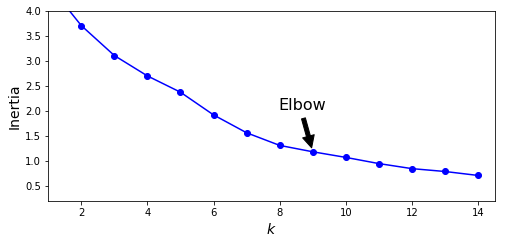

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 15), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(9, inertias[8]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 14.5, 0.2, 4])
plt.show()

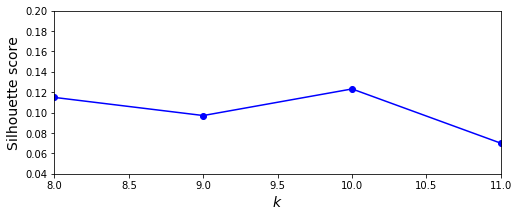

In [19]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(london_grouped_clustering, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 15), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([8, 11, 0.04, 0.2])
plt.show()

In [20]:
kclusters = 10
london_grouped_clustering = london_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)
print(kmeans.labels_[0:30])

[5 9 3 0 3 0 3 3 0 3 3 9 6 1 8 4 3 3 3 0 8 1 7 1 8 3 8 8 2 0]


In [21]:
# add clustering labels

neighbourhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
london_merged = london_data


# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
london_merged = london_merged[london_merged['Neighbourhood'] != 'Barking and Dagenham']

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
london_geo = r'london.geojson' # geojson file

london_map_final = folium.Map(location=[latitude, longitude], zoom_start=10)
london_map_final.choropleth(
    geo_data=london_geo,
    data=df_prices_london,
    columns=['Neighbourhood', 'Price (Pounds)'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Land Price in Pounds'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighbourhood'], london_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_map_final)

london_map_final

### Examining Clusters


#### Cluster 1 - Mixed Cuisine

In [23]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                        1st                         2nd  \
4        Bromley               Burger Joint    Mediterranean Restaurant   
6        Croydon   Mediterranean Restaurant  South East Asia Restaurant   
9      Greenwich       Fast Food Restaurant              Sandwich Place   
20       Lambeth  Latin American Restaurant        Caribbean Restaurant   
30    Wandsworth                Pizza Place          Chinese Restaurant   

                           3rd                    4th  \
4                  Pizza Place          Burrito Place   
6           Chinese Restaurant  East Asian Restaurant   
9   South East Asia Restaurant     Chinese Restaurant   
20    Mediterranean Restaurant  East Asian Restaurant   
30       South Asia Restaurant           Burger Joint   

                           5th             6th                    7th  \
4           Chinese Restaurant            Café  East Asian Restaurant   
6                   Restaurant            Café  South Asia Restaurant   
9     Mediterranean Restaurant    Burger Joint     African Restaurant   
20       South Asia Restaurant    Burger Joint            Pizza Place   
30  South East Asia Restaurant  Sandwich Place                   Café   

                     8th                       9th                  10th  \
4         Sandwich Place      Fast Food Restaurant                Bistro   
6   Caribbean Restaurant              Burger Joint         Burrito Place   
9             Steakhouse               Pizza Place             BBQ Joint   
20    Chinese Restaurant        African Restaurant             BBQ Joint   
30            Restaurant  Mediterranean Restaurant  Caribbean Restaurant   

    Cluster Labels  
4              0.0  
6              0.0  
9              0.0  
20             0.0  
30             0.0

#### Cluster 2 - Fast Food Restaurents

In [24]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                   1st                   2nd  \
14      Havering                  Café  Fast Food Restaurant   
22        Merton  Fast Food Restaurant                  Café   
24     Redbridge  Fast Food Restaurant        Sandwich Place   

                         3rd                            4th  \
14            Sandwich Place  Vegetarian / Vegan Restaurant   
22            Sandwich Place             Italian Restaurant   
24  Mediterranean Restaurant                   Burger Joint   

                  5th                    6th                    7th  \
14  French Restaurant    American Restaurant  Australian Restaurant   
22       Burger Joint            Pizza Place  South Asia Restaurant   
24        Pizza Place  South Asia Restaurant              BBQ Joint   

          8th                    9th                   10th  Cluster Labels  
14  BBQ Joint                 Bistro           Burger Joint             1.0  
22  BBQ Joint                 Bistro  East Asian Restaurant             1.0  
24     Bistro  Australian Restaurant  East Asian Restaurant             1.0

#### Cluster 3 - Vegan Restaurent

In [25]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                            1st          2nd  \
29  Waltham Forest  Vegetarian / Vegan Restaurant  Pizza Place   

                  3rd                  4th                    5th        6th  \
29  French Restaurant  American Restaurant  Australian Restaurant  BBQ Joint   

       7th           8th            9th  10th  Cluster Labels  
29  Bistro  Burger Joint  Burrito Place  Café             2.0

#### Cluster 4 - Incidence of Cafe, European Restaurents

In [26]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                       1st  \
3                    Brent       American Restaurant   
5                   Camden                      Café   
7                   Ealing  Mediterranean Restaurant   
8                  Enfield                      Café   
10                 Hackney                      Café   
11  Hammersmith and Fulham                      Café   
17               Islington  Mediterranean Restaurant   
18  Kensington and Chelsea    Continental Restaurant   
19    Kingston upon Thames                      Café   
26               Southwark                Restaurant   
31             Westminster            Sandwich Place   

                           2nd                         3rd  \
3        South Asia Restaurant              Sandwich Place   
5     Mediterranean Restaurant      Continental Restaurant   
7   South East Asia Restaurant          Italian Restaurant   
8               Sandwich Place                  Restaurant   
10   Middle Eastern Restaurant      Continental Restaurant   
11          Italian Restaurant  South East Asia Restaurant   
17   Middle Eastern Restaurant           French Restaurant   
18                        Café                  Restaurant   
19          Italian Restaurant   Middle Eastern Restaurant   
26           French Restaurant  South East Asia Restaurant   
31       East Asian Restaurant          Italian Restaurant   

                              4th                        5th  \
3                      Restaurant  Latin American Restaurant   
5                    Burger Joint         Italian Restaurant   
7          Continental Restaurant      East Asian Restaurant   
8       Latin American Restaurant       Fast Food Restaurant   
10  Vegetarian / Vegan Restaurant                 Restaurant   
11          South Asia Restaurant      East Asian Restaurant   
17     South East Asia Restaurant                       Café   
18          East Asian Restaurant          French Restaurant   
19          East Asian Restaurant  Latin American Restaurant   
26         Continental Restaurant                Pizza Place   
31         Continental Restaurant  Middle Eastern Restaurant   

                       6th                         7th  \
3       Italian Restaurant                       Diner   
5           Sandwich Place                  Restaurant   
7             Burger Joint                 Pizza Place   
8    South Asia Restaurant                 Pizza Place   
10      Italian Restaurant                Burger Joint   
11  Continental Restaurant          Chinese Restaurant   
17   East Asian Restaurant   Latin American Restaurant   
18            Burger Joint          Chinese Restaurant   
19  Continental Restaurant  South East Asia Restaurant   
26                    Café   Latin American Restaurant   
31                  Bistro       Street Food Gathering   

                          8th                         9th  \
3                        Café  South East Asia Restaurant   
5                 Pizza Place   Middle Eastern Restaurant   
7   Middle Eastern Restaurant          Chinese Restaurant   
8          Italian Restaurant   Middle Eastern Restaurant   
10                Pizza Place              Sandwich Place   
11   Mediterranean Restaurant              Sandwich Place   
17      South Asia Restaurant                      Bistro   
18   Mediterranean Restaurant          Italian Restaurant   
19               Burger Joint    Mediterranean Restaurant   
26      South Asia Restaurant          Italian Restaurant   
31   Mediterranean Restaurant                       Diner   

                             10th  Cluster Labels  
3              Seafood Restaurant             3.0  
5              Chinese Restaurant             3.0  
7            Fast Food Restaurant             3.0  
8        Mediterranean Restaurant             3.0  
10     South East Asia Restaurant             3.0  
11           Fast Food Restaurant             3.0  
17                   Burger Join

#### Cluster 5 - Incidence of Cafe or Chinese Restaurent

In [27]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood   1st                 2nd                            3rd  \
16      Hounslow  Café  Chinese Restaurant  Vegetarian / Vegan Restaurant   

                  4th                  5th                    6th        7th  \
16  French Restaurant  American Restaurant  Australian Restaurant  BBQ Joint   

       8th           9th           10th  Cluster Labels  
16  Bistro  Burger Joint  Burrito Place             4.0

#### Cluster 6 - Incidence of Cafe, Vegan Restaurents

In [28]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood   1st                            2nd                3rd  \
1        Barnet  Café  Vegetarian / Vegan Restaurant  French Restaurant   

                   4th                    5th        6th     7th  \
1  American Restaurant  Australian Restaurant  BBQ Joint  Bistro   

            8th            9th                  10th  Cluster Labels  
1  Burger Joint  Burrito Place  Caribbean Restaurant             5.0

#### Cluster 7 - South East Asia Restaurent

In [29]:
london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                         1st                    2nd  \
13        Harrow  South East Asia Restaurant  South Asia Restaurant   

                              3rd                   4th                  5th  \
13  Vegetarian / Vegan Restaurant  Fast Food Restaurant  American Restaurant   

                      6th        7th     8th           9th           10th  \
13  Australian Restaurant  BBQ Joint  Bistro  Burger Joint  Burrito Place   

    Cluster Labels  
13             6.0

#### Cluster 8 - Sandwich Place

In [30]:
london_merged.loc[london_merged['Cluster Labels'] == 7, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood             1st                 2nd  \
23        Newham  Sandwich Place  Chinese Restaurant   

                              3rd                4th                  5th  \
23  Vegetarian / Vegan Restaurant  French Restaurant  American Restaurant   

                      6th        7th     8th           9th           10th  \
23  Australian Restaurant  BBQ Joint  Bistro  Burger Joint  Burrito Place   

    Cluster Labels  
23             7.0

#### Cluster 9 - Italian Restaurents

In [31]:
london_merged.loc[london_merged['Cluster Labels'] == 8, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                 1st                       2nd  \
15            Hillingdon  Italian Restaurant               Pizza Place   
21              Lewisham  Italian Restaurant  Mediterranean Restaurant   
25  Richmond upon Thames  Italian Restaurant     South Asia Restaurant   
27                Sutton         Pizza Place            Sandwich Place   
28         Tower Hamlets  Italian Restaurant                      Café   

                         3rd                 4th                         5th  \
15      Fast Food Restaurant  Chinese Restaurant              Sandwich Place   
21               Pizza Place      Sandwich Place       East Asian Restaurant   
25  Mediterranean Restaurant          Steakhouse  South East Asia Restaurant   
27        Italian Restaurant                Café           French Restaurant   
28               Pizza Place  Chinese Restaurant              Sandwich Place   

                              6th                        7th  \
15                   Burger Joint  Latin American Restaurant   
21           Fast Food Restaurant                     Bistro   
25          East Asian Restaurant             Sandwich Place   
27       Mediterranean Restaurant       Fast Food Restaurant   
28  Vegetarian / Vegan Restaurant                      Diner   

                       8th                       9th           10th  \
15   South Asia Restaurant  Mediterranean Restaurant           Café   
21            Burger Joint             Burrito Place      BBQ Joint   
25    Fast Food Restaurant                 BBQ Joint    Pizza Place   
27            Burger Joint             Burrito Place          Diner   
28  Continental Restaurant      Caribbean Restaurant  Burrito Place   

    Cluster Labels  
15             8.0  
21             8.0  
25             8.0  
27             8.0  
28             8.0

#### Cluster 10 - Italian Restaurent and Fast Food Restaurents.

In [32]:
london_merged.loc[london_merged['Cluster Labels'] == 9, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

Neighbourhood                   1st                       2nd  \
2         Bexley    Italian Restaurant      Fast Food Restaurant   
12      Haringey  Fast Food Restaurant  Mediterranean Restaurant   

                         3rd                    4th                 5th  \
2   Mediterranean Restaurant         Sandwich Place  Chinese Restaurant   
12        Italian Restaurant  South Asia Restaurant                Café   

                              6th                   7th    8th  \
2   Vegetarian / Vegan Restaurant  Caribbean Restaurant  Diner   
12  Vegetarian / Vegan Restaurant  Caribbean Restaurant  Diner   

                       9th                10th  Cluster Labels  
2   Continental Restaurant       Burrito Place             9.0  
12  Continental Restaurant  Chinese Restaurant             9.0